<a href="https://colab.research.google.com/github/wikiban43/fear_speech/blob/main/fear_speech_classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Important methods to be run all the time

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install nltk

In [3]:
def preprocess(text):
  text = text.lower()
  text = text.replace(".","")
  text = text.replace(",","")
  text = text.replace(":","")
  text = text.replace(";","")
  text = text.replace("\'","")
  text = text.replace("\"","")
  text = text.replace("?","")
  text = text.replace("/","")
  text = text.replace(">","")
  text = text.replace("<","")
  text = text.replace("+","")
  text = text.replace("=","")
  text = text.replace(")","")
  text = text.replace("(","")
  text = text.replace("]","")
  text = text.replace("[","")
  text = text.replace("}","")
  text = text.replace("{","")
  text = text.replace("*","")
  text = text.replace("&","")
  text = text.replace("^","")
  text = text.replace("%","")
  text = text.replace("$","")
  text = text.replace("#","")
  text = text.replace("@","")
  text = text.replace("!","")
  text = text.replace('“','')
  text = text.replace('’','')
  text = text.replace('”','')

  return text

In [4]:
def get_clean_text(article):
  '''
  Method to remove all puncts and stopwords from an article and return the clean article.
  '''
  from nltk.corpus import stopwords
  en_stops = set(stopwords.words('english'))
  #print(article)
  try:
    article = preprocess(article)
  except:
    return article
  art_words = article.split(" ")
    #print(art_words)
  clean_art_words=[]
  for word in art_words:
    #word = ''.join(filter(str.isalnum, word))
    if word not in en_stops:
      clean_art_words.append(word)
  article = " ".join(clean_art_words)
  return article

In [5]:
import json
import pandas as pd
#Read huffpost data and convert to df
path = "drive/My Drive/"
#Read dataset and convert it to dataframe
try:
    df = pd.read_csv(path + "fear_speech.csv", delimiter='|')
    df.head()
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Print the problematic line for inspection
    with open(path + "fear_speech.csv", 'r') as file:
        for i, line in enumerate(file):
            if i == 20:  # Line numbers are zero-based
                print(f"Line 21: {line}")
                break

In [6]:
df.head()

,text,labels
0,Administrator Committee Islamic name of...,"Fear speech, Fear speech, Normal ,"
1,Blast 16 killed and 100 injured in Hyderabads...,"Normal, Normal, Normal ,"
2,1 Islam is not a religion but a mental dise...,"Fear speech, Fear speech, Normal ,"
3,JamaateIslami has more resources than Pakista...,"Fear speech, Normal, Normal ,"
4,Urban Naxalism Maoism Just a request start re...,"Normal, Normal, Fear speech ,"


#Load the saved df and run from here

In [7]:
#df.to_csv(path+"final_data_200K.csv")
import pickle

In [8]:
!pip3 install transformers

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#example_text = 'I will watch Memento tonight'
#bert_input = tokenizer(example_text,padding='max_length', max_length = 10,truncation=True, return_tensors="pt")


#print(bert_input['input_ids'])
#print(bert_input['token_type_ids'])
#print(bert_input['attention_mask'])

#example_text = tokenizer.decode(bert_input.input_ids[0])

#print(example_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
import pandas as pd
import os

In [11]:
import glob
glob.glob(path)

['drive/My Drive/']

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
#df = df_samp
df = df.dropna()
#df[["headline","category"]].astype(str)

df["text"] = df["text"].apply(lambda x: get_clean_text(x))

In [14]:
def get_majority_label(text):
    text = str(text)
    text_l = text.split(',')
    from collections import Counter
    c = Counter(text_l)
    return c.most_common()[0][0]

df["major_label"]=df["labels"].apply(lambda x: get_majority_label(x))

In [15]:
df.head()

,text,labels,major_label
0,administrator committee islamic name te...,"Fear speech, Fear speech, Normal ,",Fear speech
1,blast 16 killed 100 injured hyderabads mecca ...,"Normal, Normal, Normal ,",Normal
2,1 islam religion mental disease xi jinping...,"Fear speech, Fear speech, Normal ,",Fear speech
3,jamaateislami resources pakistan 70 bank acco...,"Fear speech, Normal, Normal ,",Fear speech
4,urban naxalism maoism request start reading 1...,"Normal, Normal, Fear speech ,",Normal


In [17]:
import torch

In [18]:
import torch
torch.cuda.empty_cache()
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Normal':0,'Fear speech':1,}
#labels = d
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        #print(labels)
        #Get the labels and the tokenized text (padded if necessary) in two variables
        try:
          self.labels = [labels[label] for label in df['major_label']]
        except:
          print("Categories unnecessary or incorrect.")
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        #Get labels
        return self.labels

    def __len__(self):
        #Get number of labels
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch (certain list) of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch (certain list) of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        #Get a batch of inputs and labels together
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [19]:
df = df.drop("labels",axis=1)
df.head()

,text,major_label
0,administrator committee islamic name te...,Fear speech
1,blast 16 killed 100 injured hyderabads mecca ...,Normal
2,1 islam religion mental disease xi jinping...,Fear speech
3,jamaateislami resources pakistan 70 bank acco...,Fear speech
4,urban naxalism maoism request start reading 1...,Normal


In [20]:
#np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

3824 478 478


In [21]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        #Initialize the pretrained bert model, dropout, linear, and relu layers
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 41)  #Dimensions of the final CLS embedding and the number of labels
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # Ensure mask is 2D
        mask = mask.squeeze(1)
        #Get the pooled output by running bert on the input IDs
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        #Get the dropped out output
        dropout_output = self.dropout(pooled_output)
        #Get the linear output
        linear_output = self.linear(dropout_output)
        #Get the final output
        final_layer = self.relu(linear_output)

        return final_layer

In [22]:
df_train.head()

,text,major_label
2351,muslims equal share ah hindu shakti dal deman...,Normal
2544,must read tell headline ill rest cover page...,Normal
2665,bastards taj mahal muslims built red fort ...,Normal
1538,rising lehenga rising respect till 1980 g...,Normal
1185,hindu jan jagriti samiti miracles sai chan...,Normal


In [58]:
from torch.optim import Adam
from tqdm import tqdm
import pickle


def train(model, train_data, val_data, learning_rate, epochs):
    #Get the texts and labels for train and validation data
    train, val = Dataset(train_data), Dataset(val_data)
    #Batch size
    bs = 8
    #Get the train and validation data loaders (memory efficient versions by torch)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=bs)
    #If GPU is available use GPU or CPU
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    #Cross entropy loss
    criterion = nn.CrossEntropyLoss()
    #Adam or any other optimizer
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            #from torchsummary import summary
            #print(summary(model,input_size=(768,),depth=1,batch_dim=1, dtypes=['torch.IntTensor']))
            #print(summary(model,(1,512,300)))

            criterion = criterion.cuda()
    else:
      torch.load(map_location=torch.device('cpu'))

    #For each epoch
    for epoch_num in range(0,epochs):
            #Initialize train and validation accuracy
            total_acc_train = 0
            total_loss_train = 0
            #print(next(iter(train_dataloader))[0])
            #For each input text and label in the train dataloader
            for train_input, train_label in tqdm(train_dataloader):
                #Load the train labels (size = batch size) in memory using the device being used
                #print(train_label)
                train_label = train_label.to(device)
                #Load the mask of the training data in the memory
                mask = train_input['attention_mask'].to(device)
                #print(mask)
                #Load the the training data (size = batch size) in the memory
                input_id = train_input['input_ids'].squeeze(1).to(device)
                #print(input_id)
                #Do the forward pass on the model
                output = model(input_id, mask)
                #Get the batch loss
                batch_loss = criterion(output, train_label.long())
                #Calculate total loss till this batch loss
                total_loss_train += batch_loss.item()
                #Get the accuracy for this batch
                acc = (output.argmax(dim=1) == train_label).sum().item()
                #Add to the total training accuracy
                total_acc_train += acc

                model.zero_grad()
                #Backpropagation
                batch_loss.backward()
                optimizer.step()
            #Repeat the same steps as above for validation data
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            #Print the performance metric for this epoch
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            pickle.dump(model,open(path+"fear_speech_classification.epoch"+str(epoch_num)+".pickle","wb"))
    #return model

EPOCHS = 10
model = BertClassifier()
#model = torch.load(open(path+"topic_classification_model_sample.epoch"+str(11)+".pickle"),map_location=torch.device('cpu'))
#model = pickle.load(open(path+"topic_classification_model_sample.epoch"+str(2)+".pickle","rb"))
#model = pickle.load(open(path+"topic_classification_model_new.epoch"+str(4)+".pickle","rb"))
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)


100%|██████████| 478/478 [05:46<00:00,  1.38it/s]


Epochs: 1 | Train Loss:  0.227                 | Train Accuracy:  0.534                 | Val Loss:  0.127                 | Val Accuracy:  0.674


100%|██████████| 478/478 [05:52<00:00,  1.36it/s]


Epochs: 2 | Train Loss:  0.109                 | Train Accuracy:  0.662                 | Val Loss:  0.098                 | Val Accuracy:  0.690


100%|██████████| 478/478 [05:52<00:00,  1.35it/s]


Epochs: 3 | Train Loss:  0.089                 | Train Accuracy:  0.685                 | Val Loss:  0.090                 | Val Accuracy:  0.692


100%|██████████| 478/478 [05:52<00:00,  1.35it/s]


Epochs: 4 | Train Loss:  0.079                 | Train Accuracy:  0.727                 | Val Loss:  0.080                 | Val Accuracy:  0.707


100%|██████████| 478/478 [05:52<00:00,  1.35it/s]


Epochs: 5 | Train Loss:  0.070                 | Train Accuracy:  0.758                 | Val Loss:  0.078                 | Val Accuracy:  0.709


100%|██████████| 478/478 [05:52<00:00,  1.35it/s]


Epochs: 6 | Train Loss:  0.062                 | Train Accuracy:  0.796                 | Val Loss:  0.083                 | Val Accuracy:  0.715


100%|██████████| 478/478 [05:52<00:00,  1.36it/s]


Epochs: 7 | Train Loss:  0.055                 | Train Accuracy:  0.836                 | Val Loss:  0.082                 | Val Accuracy:  0.699


100%|██████████| 478/478 [05:52<00:00,  1.35it/s]


Epochs: 8 | Train Loss:  0.048                 | Train Accuracy:  0.860                 | Val Loss:  0.074                 | Val Accuracy:  0.720


100%|██████████| 478/478 [05:52<00:00,  1.36it/s]


Epochs: 9 | Train Loss:  0.040                 | Train Accuracy:  0.900                 | Val Loss:  0.079                 | Val Accuracy:  0.701


100%|██████████| 478/478 [05:52<00:00,  1.35it/s]


Epochs: 10 | Train Loss:  0.033                 | Train Accuracy:  0.925                 | Val Loss:  0.084                 | Val Accuracy:  0.690


In [59]:
while True:pass

KeyboardInterrupt: 

Test Accuracy:  0.692


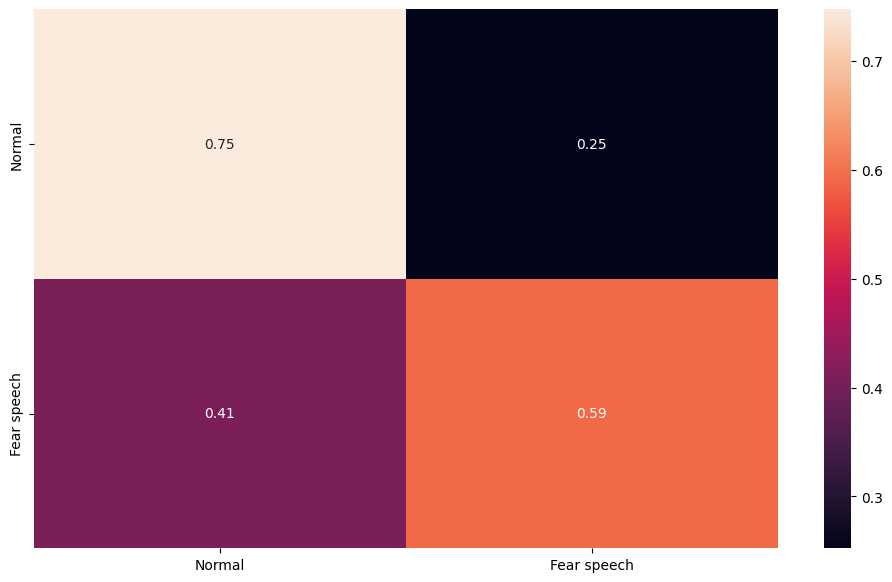

In [29]:
import pickle
import  matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
path = "drive/My Drive/"
classes = ('Normal','Fear speech')
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    #use_cuda = torch.cuda.is_available()
    #device = torch.device("cuda" if use_cuda else "cpu")

    #In mandatory cpu mode
    device = torch.device("cuda")

    #if use_cuda:
    #    model = model.cuda()
    y_true = []
    y_pred = []
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              #output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
              y_true.extend(test_label.cpu())

              #print(test_label)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              #Output is 41,batchsize dimensional. 41 is the number of labels in the data
              output = model(input_id, mask)
              y_pred.extend(output.argmax(dim=1).cpu())  # Save Prediction
              #print("****************")
              #print(output.argmax(dim=1))
              #print(test_label)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')
    plt.show()


model = pickle.load(open(path+"fear_speech_classification.epoch9.pickle","rb"))
#infer_topic(model, df_final_test)
evaluate(model,df_test)






In [64]:
#df_final_test.head()
df_test['major_label'].value_counts()

major_label
Normal         309
Fear speech    169
Name: count, dtype: int64

In [ ]:
!pip install tensorflow_hub
!pip install tensorflow_text